# Project 1 Revisited: Core Assignment 1

- Name: Tyler Schelling
- Start Date: 1/23/2023

## Task

- For this assignment, you will revisit your first project to predict supermarket sales. You will apply what you've learned this week to explain how your models made their predictions.

## Part 1: Remaking, Saving, and Explaining Your Models

For this part of the project, you will be producing a new version of your final project notebook using the updated tools in sklearn v1.1. 

- Create a new notebook called "Project 1 - Revisited.ipynb" in your project repo.
    - You may either make a copy of your prior notebook that you will modify,
or you can start a new blank notebook and copy over the code from your old notebook (as needed).
- Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.

### Import Libraries

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss
import math

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
import statsmodels.api as sm

## setting random state for reproducibility
SEED = 42
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [2]:
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


### Load the Data

In [3]:
#Load the data and examine the dataset we will be using
df = pd.read_csv('Data/sales_predictions.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
df['Outlet_Size'].replace('High', 'Large', inplace = True)

### Preprocessing (with Sklearn v1.1+)

In [6]:
target = 'Item_Outlet_Sales'
drop_feats = []

X = df.drop(columns=[target, *drop_feats]).copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,NCG06,16.35,Low Fat,0.029565,Household,256.4646,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,FDV57,15.25,Regular,0.000000,Snack Foods,179.7660,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,FDM27,12.35,Regular,0.158716,Meat,157.2946,OUT049,1999,Medium,Tier 1,Supermarket Type1


#### Impute Missing Item_Weights

In [7]:
#Loop through the index of the Dataframe
for ind in X_train.index:
    #Create a variable to hold the Item_Identifier of the current index
    item_id = X_train.loc[ind,'Item_Identifier']

    #Check if the location of the Item_Weight at the index is null
    #Create a filter to filter out only 'Item_Identifier' values equivalent to the item_id
    #Replace the null value with the .mean() of the 'Item_Weight' for the current 'Item_Identifier'. Values across 'Item_Identifier's are consistent.
    if X_train.isnull().loc[ind, 'Item_Weight']:
        item_filter = X_train['Item_Identifier'] == item_id
        X_train.loc[ind, 'Item_Weight'] = X_train[item_filter]['Item_Weight'].mean()

        #Additional check for the case of the null 'Item_Weight' being the only value for the 'Item_Identifier'
        #Create a new filter to filter out only the 'Item_Type' values of the current index.
        #Replace the null values with the .mean() of the 'Item_Weight' for the item's 'Item_Type'
        if math.isnan(X_train[item_filter]['Item_Weight'].mean()):
            type_filter = X_train['Item_Type'] == X_train.loc[ind, 'Item_Type']
            X_train.loc[ind, 'Item_Weight'] = X_train[type_filter]['Item_Weight'].median()

#### X_test Item_Weight Imputation Based on X_train Values

In [8]:
#Loop through the index of the Dataframe
for ind in X_test.index:
    #Create a variable to hold the Item_Identifier of the current index
    item_id = X_test.loc[ind,'Item_Identifier']

    #Check if the location of the Item_Weight at the index is null
    #Create a filter to filter out only 'Item_Identifier' values equivalent to the item_id
    #Replace the null value with the .mean() of the 'Item_Weight' for the current 'Item_Identifier'. Values across 'Item_Identifier's are consistent.
    if X_test.isnull().loc[ind, 'Item_Weight']:
        item_filter = X_train['Item_Identifier'] == item_id
        X_test.loc[ind, 'Item_Weight'] = X_train[item_filter]['Item_Weight'].mean()

        #Additional check for the case of the null 'Item_Weight' being the only value for the 'Item_Identifier'
        #Create a new filter to filter out only the 'Item_Type' values of the current index.
        #Replace the null values with the .mean() of the 'Item_Weight' for the item's 'Item_Type'
        if math.isnan(X_train[item_filter]['Item_Weight'].mean()):
            type_filter = X_train['Item_Type'] == X_test.loc[ind, 'Item_Type']
            X_test.loc[ind, 'Item_Weight'] = X_train[type_filter]['Item_Weight'].median()

In [9]:
X_train = X_train.drop(columns = 'Item_Identifier')
X_test = X_test.drop(columns = 'Item_Identifier')

#### Instantiate Column Selectors and Transformers

In [10]:
num_selector = make_column_selector(dtype_include='number')

# Split ordinal columns out
ord_cols = ['Outlet_Size', 'Outlet_Location_Type']
cat_cols = df.select_dtypes('object').columns.difference(['Outlet_Size', 'Outlet_Location_Type', 'Item_Identifier']).to_list()

In [11]:
# Simple Imputer
freq_imputer = SimpleImputer(strategy = 'most_frequent')
# Scaler
scaler = StandardScaler()
# One Hot Encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

#### Ordinal Encoder

In [12]:
# Create a list of ordinal labels
out_size_labels = ['Small', 'Medium', 'Large', 'Unknown']
out_loc_type = ['Tier 1', 'Tier 2', 'Tier 3']

# Combine the ordered list in the order that the columns appear
ordered_labels = [out_size_labels, out_loc_type]

# Instantiate OrdinalEncoder
ordinal = OrdinalEncoder(categories = ordered_labels)

#### Instantiate Pipelines

In [13]:
# Pipeline for numerals and categories
num_pipe = make_pipeline(scaler)
ord_pipe = make_pipeline(freq_imputer, ordinal)
cat_pipe = make_pipeline(freq_imputer, ohe)

#### Preprocessor

In [14]:
num_tuple = (num_pipe, num_selector)
ord_tuple = (ord_pipe, ord_cols)
cat_tuple = (cat_pipe, cat_cols)

In [15]:
preprocessor = make_column_transformer(num_tuple, cat_tuple, ord_tuple, remainder = 'passthrough', verbose_feature_names_out=False)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000029B4F6BFE20>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Identifier', 'Outlet_Type']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'Large',
                                                                              'Unknown'],
                                                                             ['Tier '
                                                                              '1',
                                                                              'Tier '
                                                                              '2',
                                                                              'Tier '
                                                                              '3']]))]),
                                 ['Outlet_Size', 'Outlet_Location_Type'])],
                  verbose_feature_names_out=False)

### Dataframes of X_train and X_test

In [16]:
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size,Outlet_Location_Type
4776,0.736477,-0.712775,1.828109,1.327849,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
7510,0.498624,-1.291052,0.603369,1.327849,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
5828,-0.128441,1.813319,0.244541,0.136187,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5327,-1.074445,-1.004931,-0.952591,0.732018,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4810,1.385165,-0.965484,-0.336460,0.493686,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,-0.767399,4.309657,-0.044657,0.017021,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0
5191,0.574304,1.008625,-1.058907,1.089517,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
5390,1.006763,-0.920527,1.523027,0.493686,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
860,1.601394,-0.227755,-0.383777,1.089517,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


## Part 2: Linear Regression

- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.
    - Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).

### Functions

In [17]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
    print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

In [18]:
def evaluate_ols(result,X_train_df, y_train):
    """Plots a Q-Q Plot and residual plot for a statsmodels OLS regression.
    """
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2,figsize=(12,5))
    
    ## Normality 
    sm.graphics.qqplot(resid,line='45',fit=True,ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

### Linear Regression Model

In [19]:
lin_reg= LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2 = 0.56	RMSE = 1,138.96	MAE = 847.12
Test Data:	R^2 = 0.57	RMSE = 1,093.00	MAE = 804.12


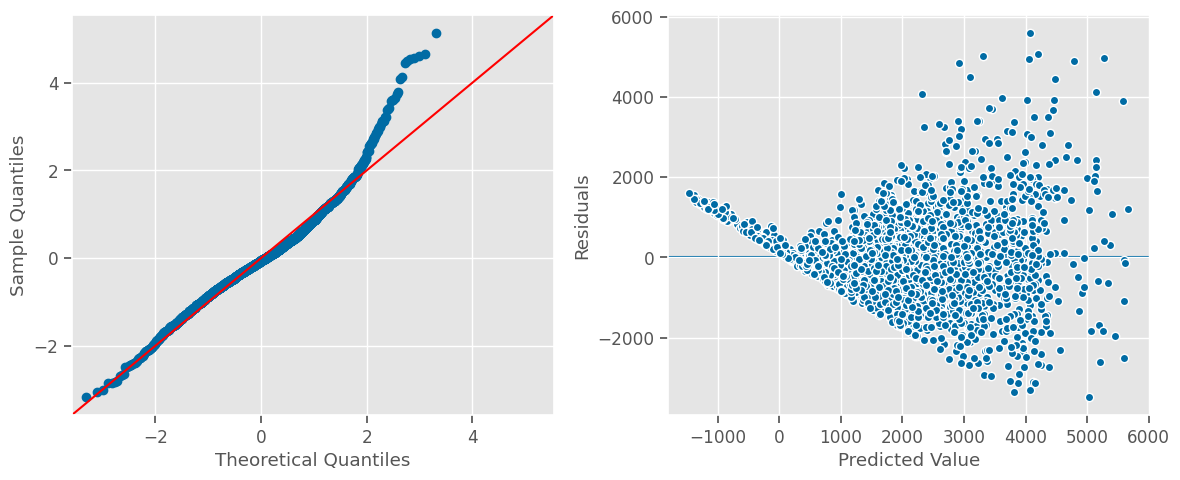

In [20]:
evaluate_ols(lin_reg, X_test_df,y_test)

### Extracting Coefficients

In [21]:
coeffs = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_)
coeffs.loc['intercept'] = lin_reg.intercept_
pd.set_option('display.float_format',  lambda x: f'{x:,.0f}')
coeffs.sort_values()

Outlet_Identifier_OUT013          -1,277,244,916,989,999
Outlet_Identifier_OUT027          -1,112,981,856,667,591
Outlet_Type_Supermarket Type3     -1,035,005,101,602,017
Outlet_Establishment_Year           -961,589,405,783,180
Outlet_Identifier_OUT019            -856,294,628,731,734
Outlet_Type_Grocery Store           -712,920,359,249,327
Outlet_Size                         -680,358,759,882,101
Outlet_Identifier_OUT046            -232,942,450,197,755
Item_Fat_Content_LF                 -230,578,076,138,805
Item_Fat_Content_reg                -230,578,076,138,790
Item_Fat_Content_Low Fat            -230,578,076,138,746
Item_Fat_Content_low fat            -230,578,076,138,682
Item_Fat_Content_Regular            -230,578,076,138,682
Outlet_Identifier_OUT035             -60,385,335,816,817
intercept                            -21,122,232,006,494
Item_Visibility                                      -21
Item_Weight                                           -8
Item_MRP                       

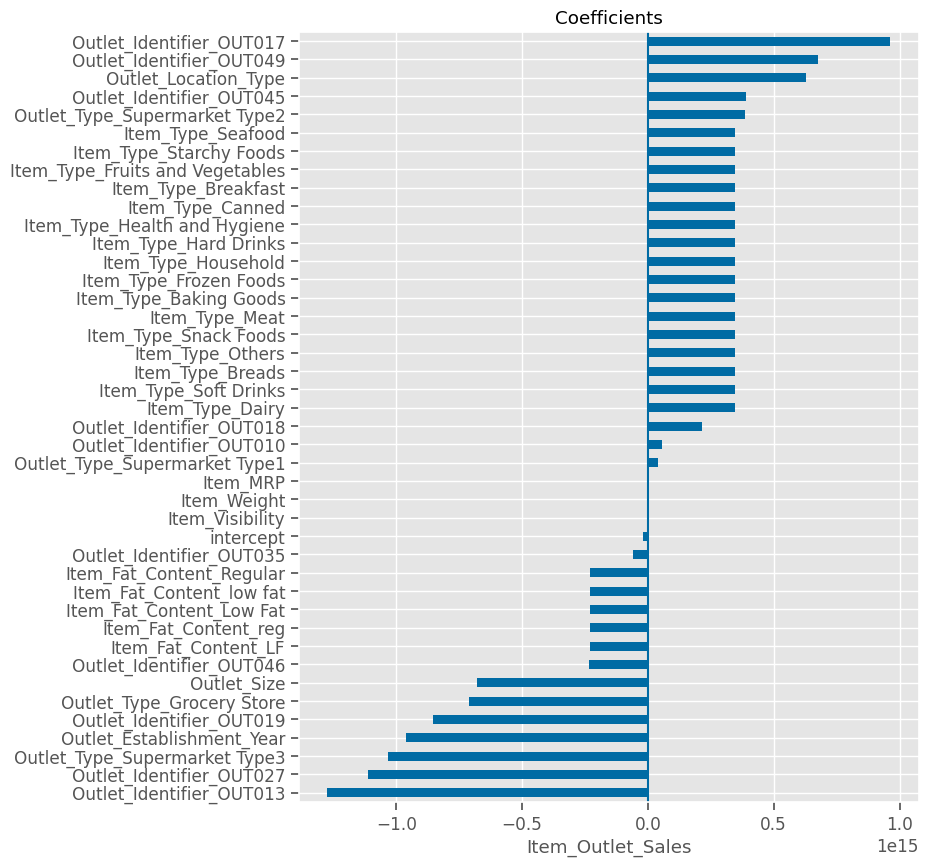

In [22]:
ax = coeffs.sort_values().plot(kind='barh', figsize = (8,10))
ax.axvline(0)
ax.set(xlabel='Item_Outlet_Sales', title = 'Coefficients');

### Recreate X/y Data with `drop='first'`

In [23]:
target = 'Item_Outlet_Sales'
drop_feats = []

X = df.drop(columns=[target, *drop_feats]).copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,NCG06,16,Low Fat,0,Household,256,OUT018,2009,Medium,Tier 3,Supermarket Type2
7510,FDV57,15,Regular,0,Snack Foods,180,OUT018,2009,Medium,Tier 3,Supermarket Type2
5828,FDM27,12,Regular,0,Meat,157,OUT049,1999,Medium,Tier 1,Supermarket Type1


In [24]:
#Loop through the index of the Dataframe
for ind in X_train.index:
    #Create a variable to hold the Item_Identifier of the current index
    item_id = X_train.loc[ind,'Item_Identifier']

    #Check if the location of the Item_Weight at the index is null
    #Create a filter to filter out only 'Item_Identifier' values equivalent to the item_id
    #Replace the null value with the .mean() of the 'Item_Weight' for the current 'Item_Identifier'. Values across 'Item_Identifier's are consistent.
    if X_train.isnull().loc[ind, 'Item_Weight']:
        item_filter = X_train['Item_Identifier'] == item_id
        X_train.loc[ind, 'Item_Weight'] = X_train[item_filter]['Item_Weight'].mean()

        #Additional check for the case of the null 'Item_Weight' being the only value for the 'Item_Identifier'
        #Create a new filter to filter out only the 'Item_Type' values of the current index.
        #Replace the null values with the .mean() of the 'Item_Weight' for the item's 'Item_Type'
        if math.isnan(X_train[item_filter]['Item_Weight'].mean()):
            type_filter = X_train['Item_Type'] == X_train.loc[ind, 'Item_Type']
            X_train.loc[ind, 'Item_Weight'] = X_train[type_filter]['Item_Weight'].median()

In [25]:
#Loop through the index of the Dataframe
for ind in X_test.index:
    #Create a variable to hold the Item_Identifier of the current index
    item_id = X_test.loc[ind,'Item_Identifier']

    #Check if the location of the Item_Weight at the index is null
    #Create a filter to filter out only 'Item_Identifier' values equivalent to the item_id
    #Replace the null value with the .mean() of the 'Item_Weight' for the current 'Item_Identifier'. Values across 'Item_Identifier's are consistent.
    if X_test.isnull().loc[ind, 'Item_Weight']:
        item_filter = X_train['Item_Identifier'] == item_id
        X_test.loc[ind, 'Item_Weight'] = X_train[item_filter]['Item_Weight'].mean()

        #Additional check for the case of the null 'Item_Weight' being the only value for the 'Item_Identifier'
        #Create a new filter to filter out only the 'Item_Type' values of the current index.
        #Replace the null values with the .mean() of the 'Item_Weight' for the item's 'Item_Type'
        if math.isnan(X_train[item_filter]['Item_Weight'].mean()):
            type_filter = X_train['Item_Type'] == X_test.loc[ind, 'Item_Type']
            X_test.loc[ind, 'Item_Weight'] = X_train[type_filter]['Item_Weight'].median()

In [26]:
X_train = X_train.drop(columns = 'Item_Identifier')
X_test = X_test.drop(columns = 'Item_Identifier')

In [27]:
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), 
                        OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'), 
                        StandardScaler())

num_sel = make_column_selector(dtype_include='number')
cat_sel = make_column_selector(dtype_include='object')

num_tuple = (num_pipe, num_sel)
cat_tuple = (cat_pipe, cat_sel)

preprocessor = make_column_transformer(num_tuple, cat_tuple, verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000029B4FEE2760>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000029B4FEE2580>)],
                  verbose_feature_names_out=False)

In [28]:
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Breads,Item_Type_Breakfast,...,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,1,-1,2,1,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
7510,0,-1,1,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
5828,-0,2,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
5327,-1,-1,-1,1,1,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
4810,1,-1,-0,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,-1,4,-0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
5191,1,1,-1,1,1,0,0,0,0,0,...,0,0,0,1,0,1,0,1,0,0
5390,1,-1,2,0,1,0,0,0,0,0,...,1,0,0,1,0,1,0,1,0,0
860,2,-0,-0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,0


#### Linear Regression Model

In [29]:
lin_reg= LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2 = 0.56	RMSE = 1,138.96	MAE = 847.11
Test Data:	R^2 = 0.57	RMSE = 1,093.03	MAE = 804.17


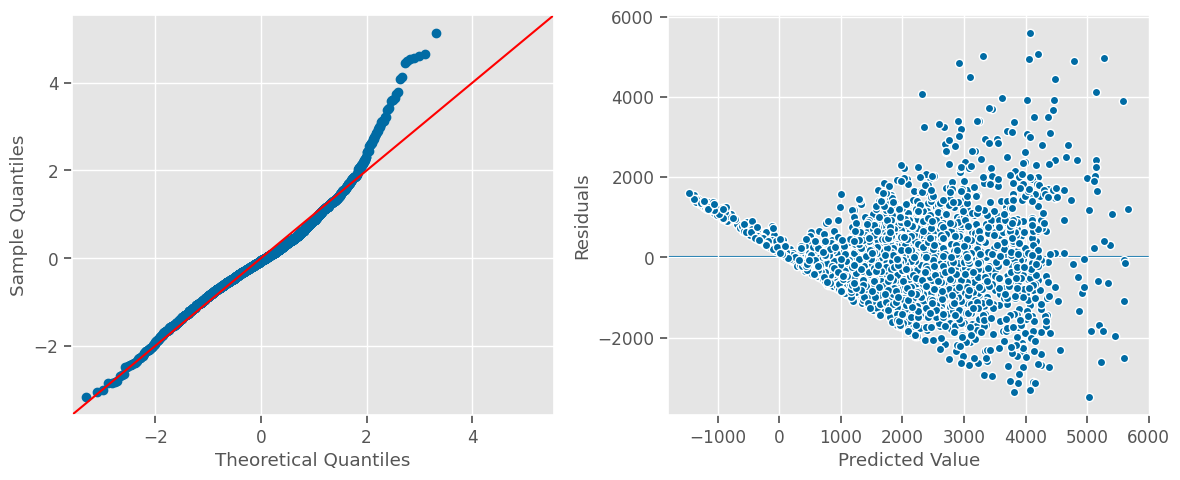

In [30]:
evaluate_ols(lin_reg, X_test_df,y_test)

#### Extracting Coefficients

In [31]:
coeffs = pd.Series(lin_reg.coef_, index=lin_reg.feature_names_in_)
coeffs.loc['intercept'] = lin_reg.intercept_
pd.set_option('display.float_format',  lambda x: f'{x:,.0f}')
coeffs.sort_values()

Outlet_Identifier_OUT019          -2,291,609,246,026,920
Outlet_Identifier_OUT013          -1,827,681,425,761,149
Outlet_Establishment_Year         -1,617,619,558,494,374
Outlet_Identifier_OUT027          -1,419,351,161,516,231
Outlet_Type_Supermarket Type3     -1,086,600,672,390,498
Outlet_Type_Supermarket Type1       -478,265,156,958,778
Outlet_Size_Small                   -358,933,849,961,352
Outlet_Size_Medium                  -185,525,800,182,609
Item_Type_Dairy                                     -107
Item_Type_Soft Drinks                                -39
Item_Type_Breads                                     -27
Item_Type_Others                                     -24
Item_Type_Snack Foods                                -22
Item_Visibility                                      -22
Item_Type_Meat                                       -12
Item_Weight                                           -8
Item_Type_Frozen Foods                                -1
Item_Type_Household            

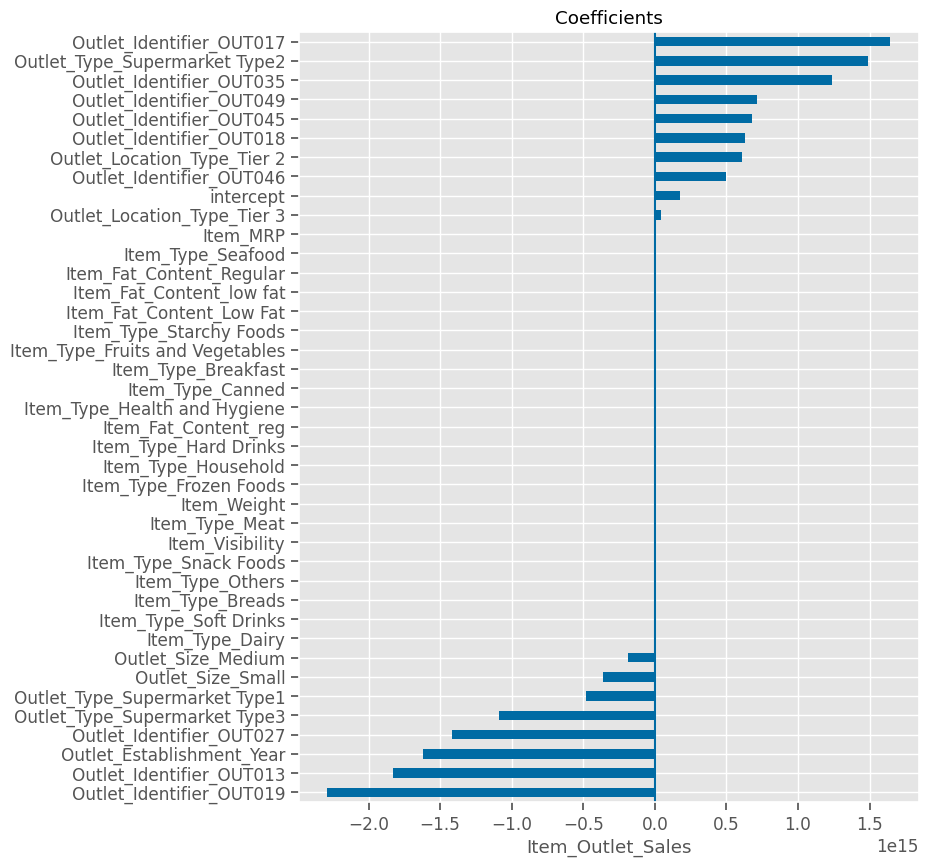

In [32]:
ax = coeffs.sort_values().plot(kind='barh', figsize = (8,10))
ax.axvline(0)
ax.set(xlabel='Item_Outlet_Sales', title = 'Coefficients')

plt.savefig('LinearRegression Coefficients.png', bbox_inches='tight');

The most impactful coefficients are:
- Outlet_Identifier_OUT019, Outlet_Identifier_OUT013, and Outlet_Identifier_OUT017

Adding drop='first' did not have a positive impact on the scale of the Item_Outlet_Sales Coefficients.

## Part 3: Tree-Based Model

- Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.
- Extract and visualize the feature importances that your model determined.
    - Identify the top 5 most important features.
- Save your figure as a .png file inside your repository  (you will need this for the final piece of this assignment - Update Your README).

### Feature Importance

In [33]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2 = 0.94	RMSE = 429.72	MAE = 297.69
Test Data:	R^2 = 0.56	RMSE = 1,106.90	MAE = 769.02


In [34]:
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
pd.set_option('display.float_format',  lambda x: f'{x:.4f}')
importances

Item_Weight                       0.0748
Item_Visibility                   0.0913
Item_MRP                          0.4340
Outlet_Establishment_Year         0.0404
Item_Fat_Content_Low Fat          0.0063
Item_Fat_Content_Regular          0.0061
Item_Fat_Content_low fat          0.0015
Item_Fat_Content_reg              0.0014
Item_Type_Breads                  0.0025
Item_Type_Breakfast               0.0024
Item_Type_Canned                  0.0041
Item_Type_Dairy                   0.0060
Item_Type_Frozen Foods            0.0058
Item_Type_Fruits and Vegetables   0.0076
Item_Type_Hard Drinks             0.0029
Item_Type_Health and Hygiene      0.0038
Item_Type_Household               0.0059
Item_Type_Meat                    0.0035
Item_Type_Others                  0.0017
Item_Type_Seafood                 0.0018
Item_Type_Snack Foods             0.0079
Item_Type_Soft Drinks             0.0053
Item_Type_Starchy Foods           0.0033
Outlet_Identifier_OUT013          0.0021
Outlet_Identifie

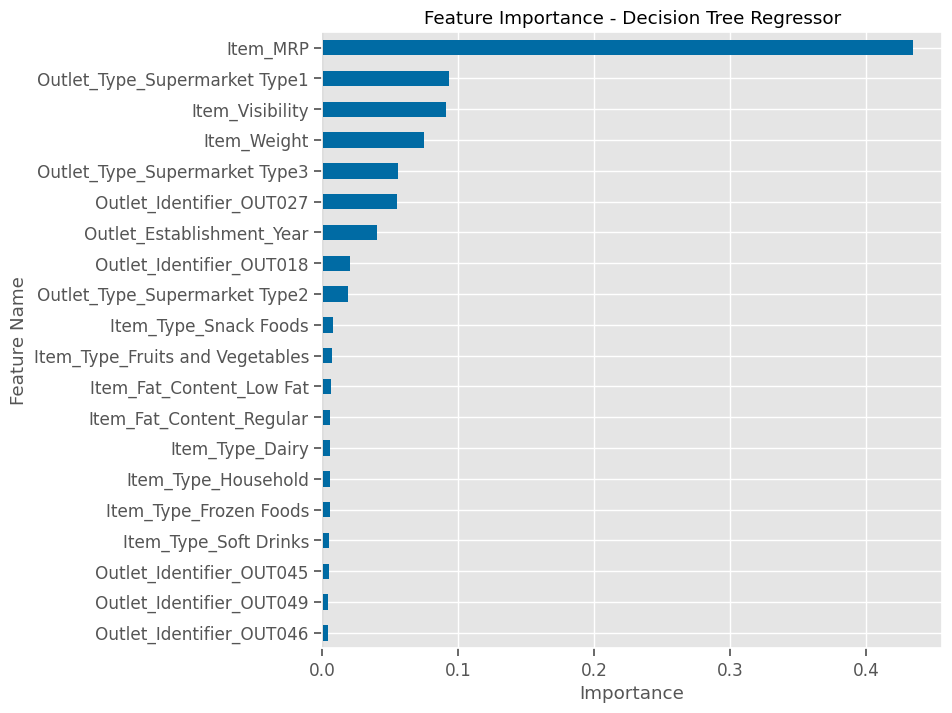

In [35]:
ax = importances.sort_values().tail(20).plot(kind='barh', figsize = (8,8))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance')

plt.savefig('Dec Tree - Feature Importance.png', bbox_inches='tight');

The top 5 most important features are:
- Item_MRP, Outlet_Type_Supermarket Type1, Item_Visibility, Item_Weight, and Outlet_Type_Supermarket Type3

## Part 4: Serialize Your Best Models with Joblib

- Once you've finished updating and explaining your models, you must save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib":
    - "preprocessor": your preprocessing  column transformer
    - "X_train": your training features.
    - "X_test": your test features.
    - "y_train": your training target.
    - "y_test": your test target.
    - "LinearRegression": your best linear regression
    - Your tree-based model's class name: your best tree-based model.
        - e.g. "RandomForestRegressor"/"DecisionTreeRegressor"
    - Save your joblib file inside your repository. (You will work with these models again in the next core assignment.)

In [36]:
export = {'preprocessor':preprocessor,
            'X_train':X_train_df,
            'X_test':X_test_df,
            'y_train': y_train,
            'y_test': y_test,
            'LinearRegression':lin_reg,
            'RandomForest':rf_reg}
joblib.dump(export, 'Core1-linreg-RF.joblib')

['Core1-linreg-RF.joblib']

## Part 5: Update your README.

- Insert your exported figures from above into your README file. You should have the following:
    - Your LinearRegression coefficients plot.
        - Your interpretation of your coefficients.
    - Your tree-based model's feature importances.
        - Your interpretation of your feature importances. 